In [10]:
from digitization import *
import glob

In [11]:
# Load models
box_model = "../3. Model training/runs/yolo11_full/weights/best.pt"
segmentation_model = "../3. Model training/runs/yolo11_patch/weights/best.pt"
lead_name_model = "../3. Model training/runs/yolo11_lead/weights/best.pt"
pulse_model = "../3. Model training/runs/yolo11_pulse/weights/best.pt"

## Digitize single image

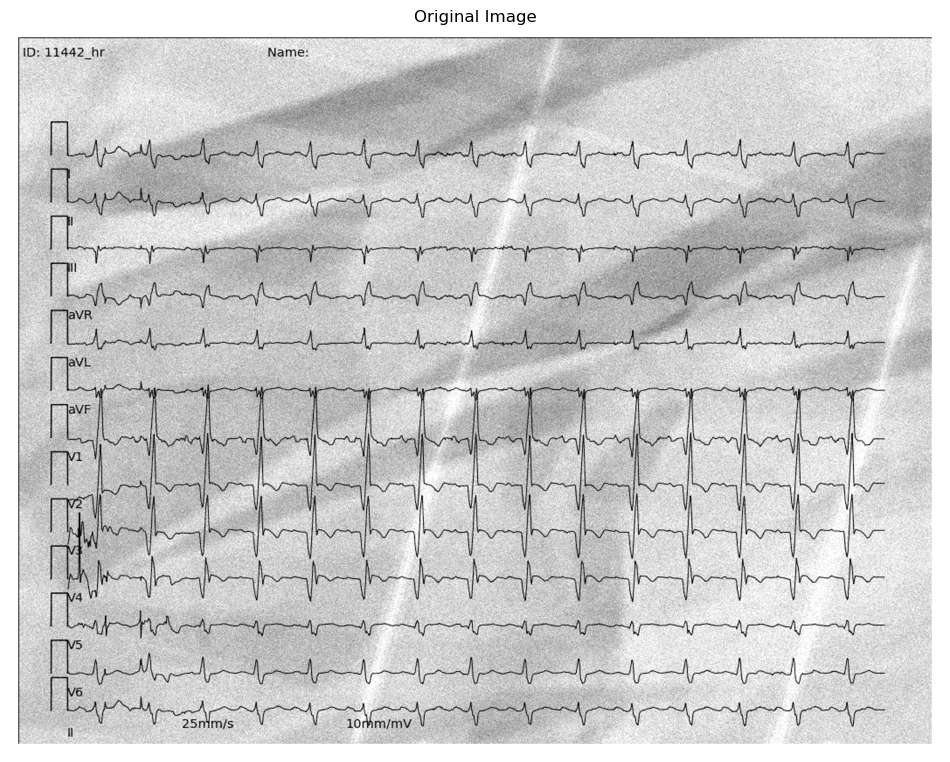

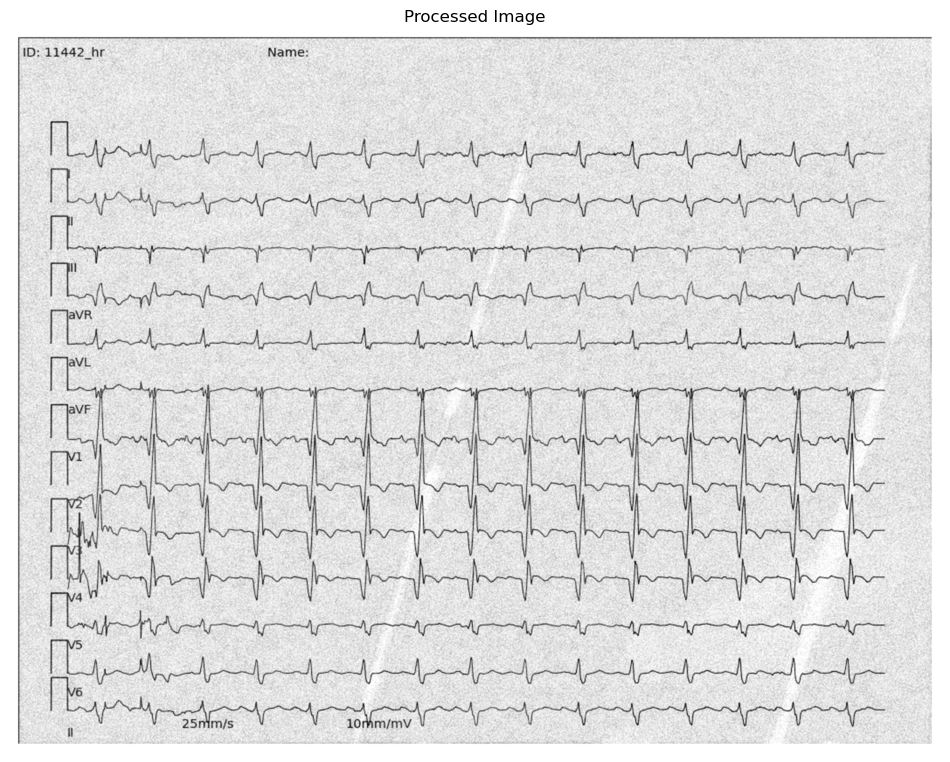

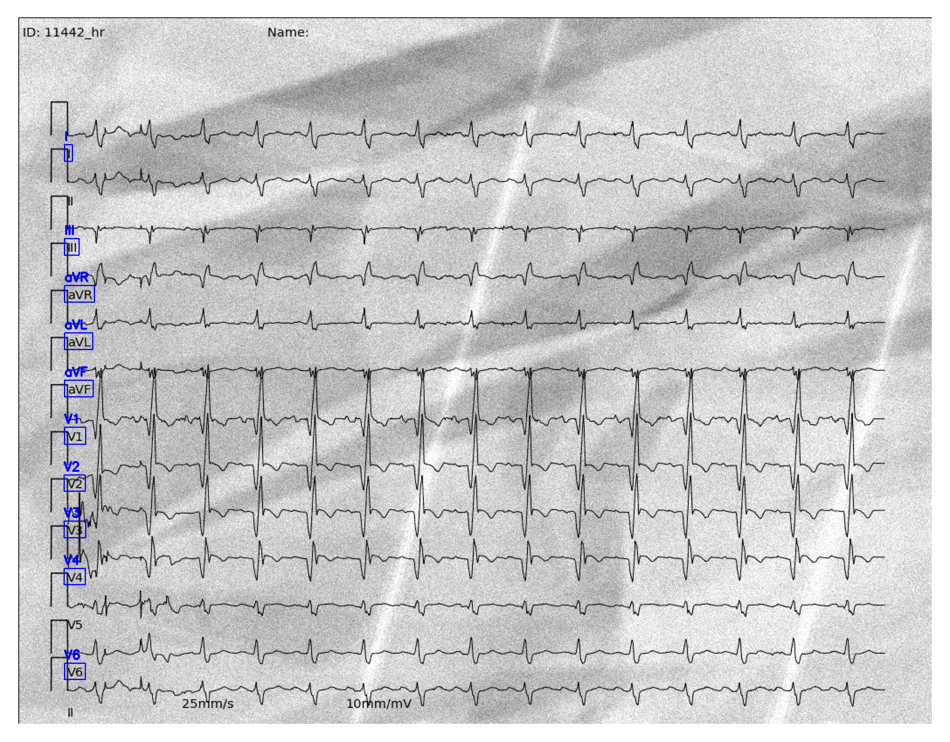

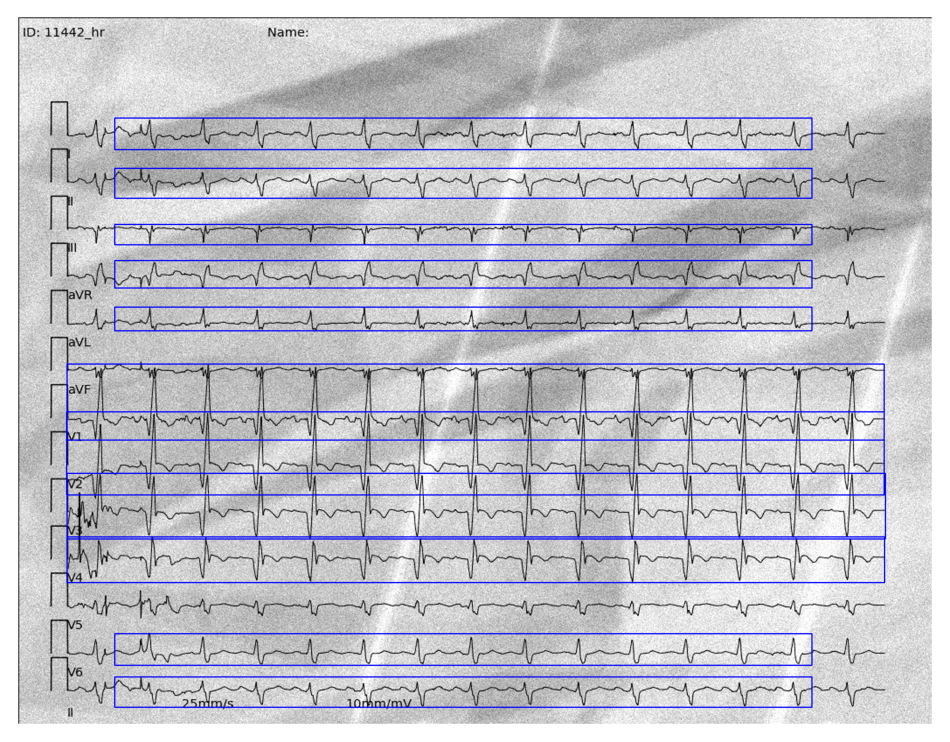

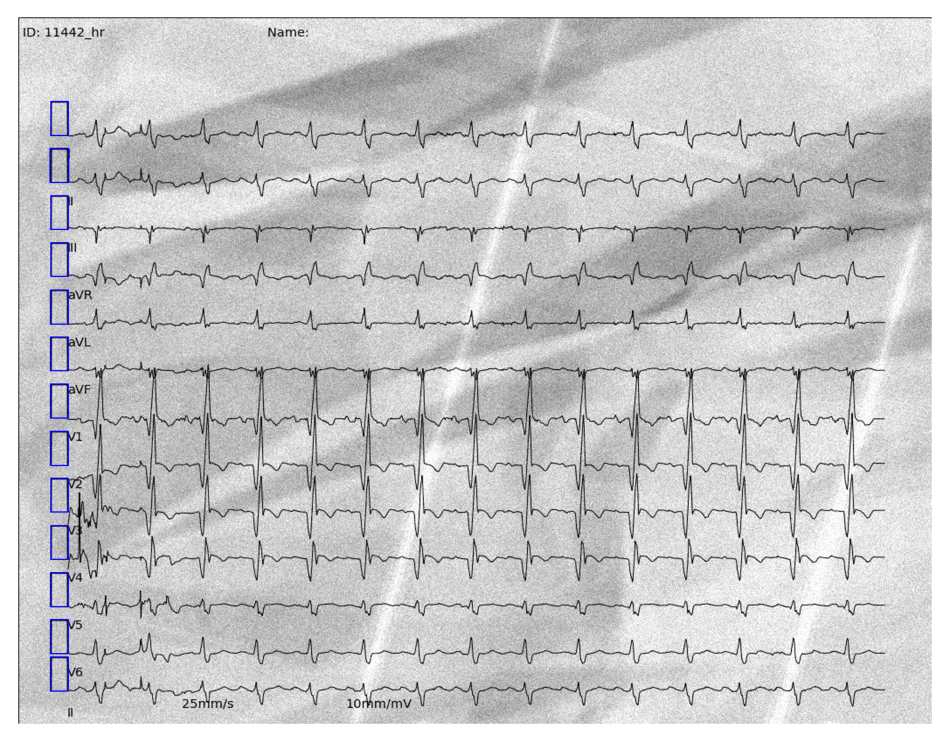

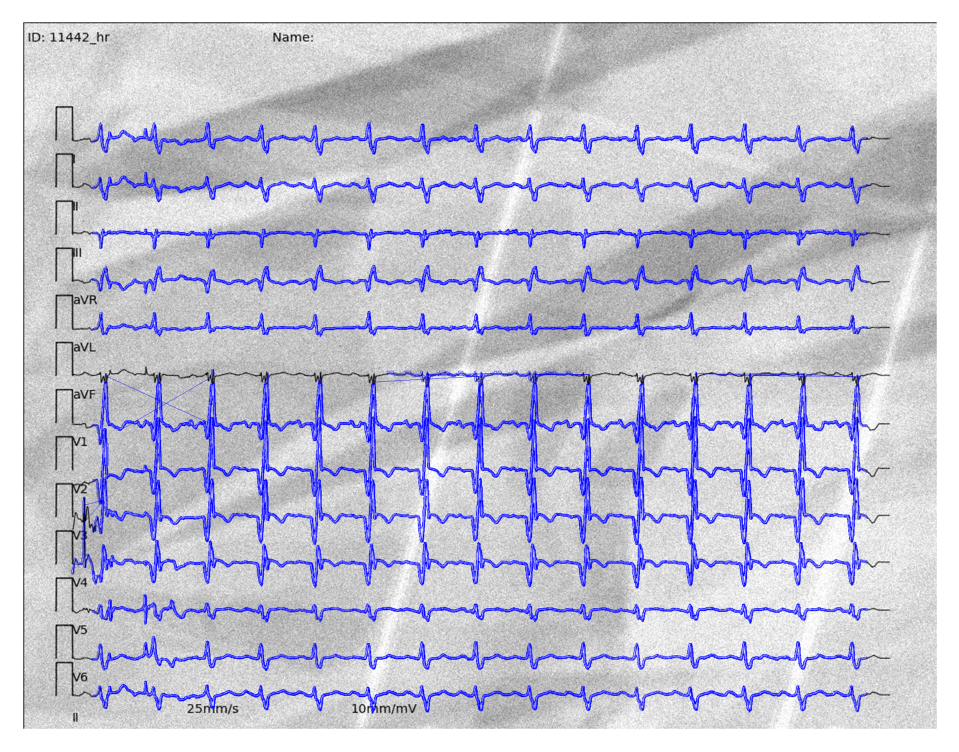

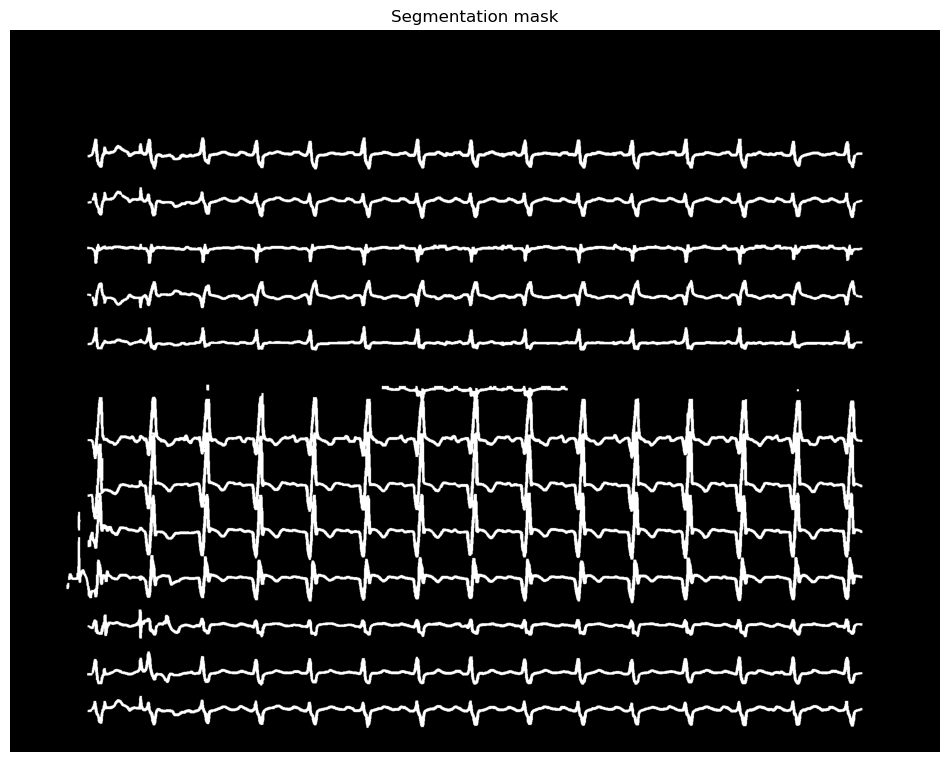

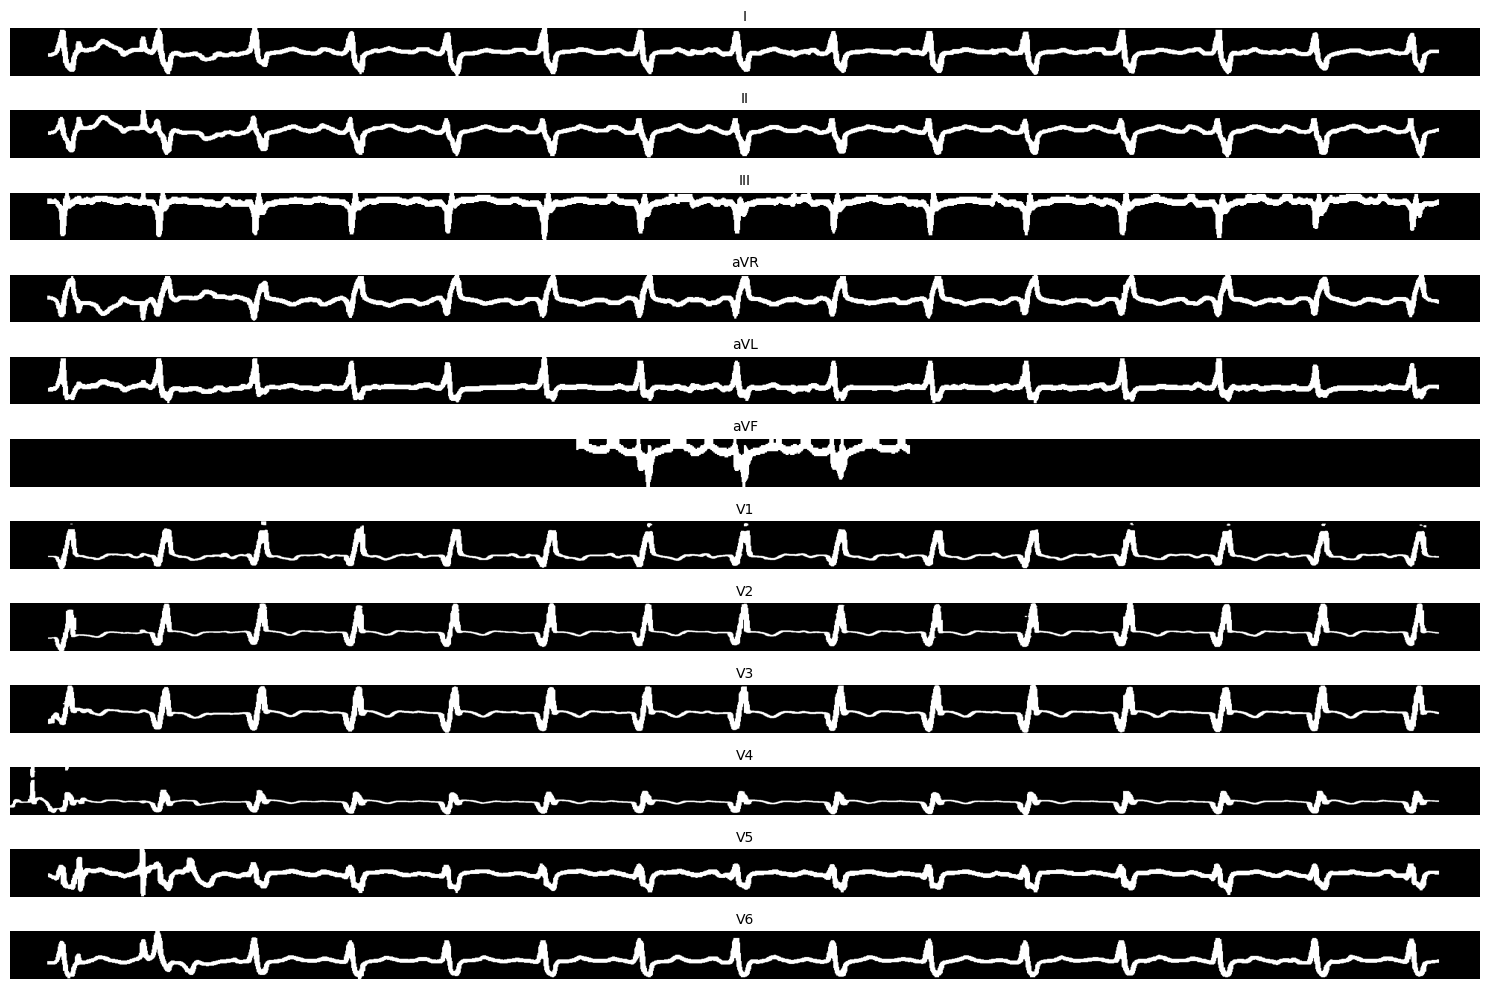

/cluster/home/cachtari/Submission code/4. Digitization pipeline/digitization.py:1074: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  signal_array = np.array(padded_signals).T


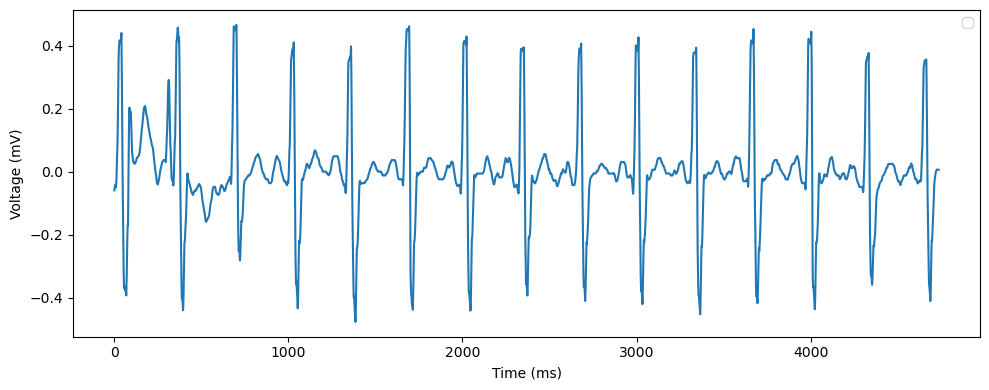

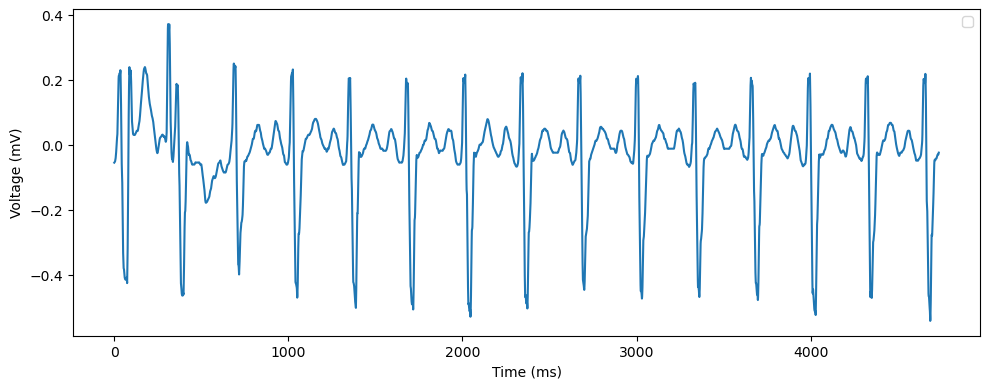

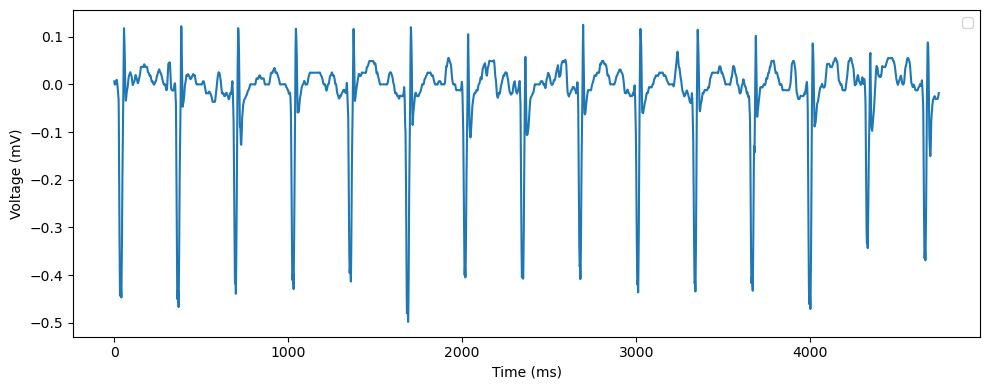

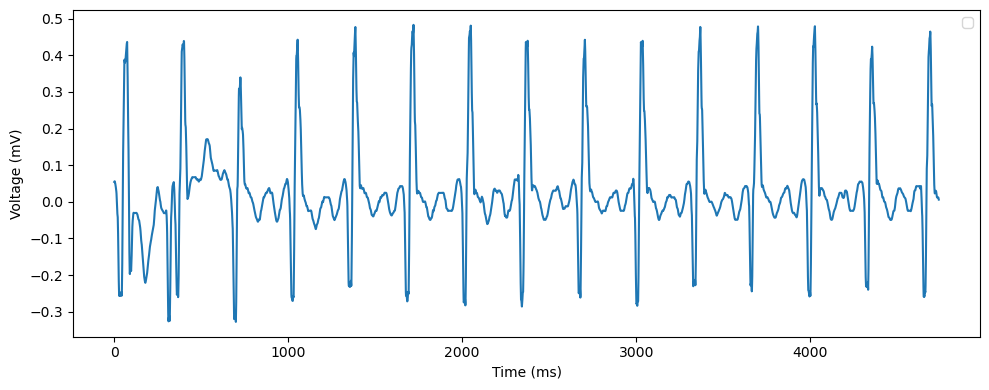

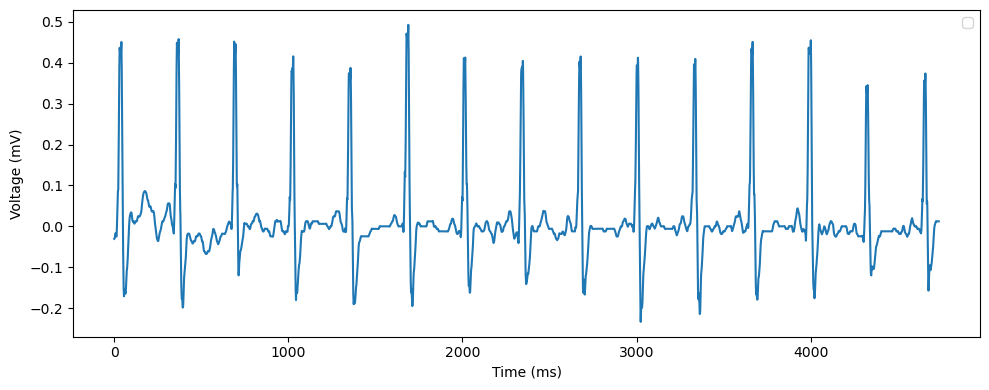

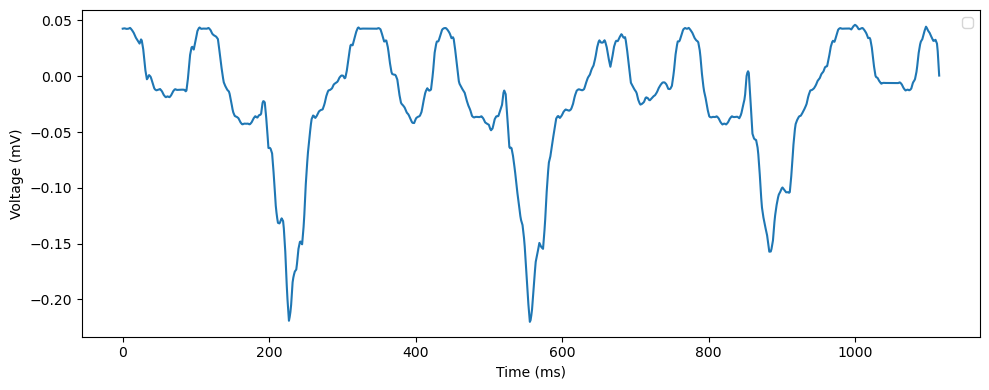

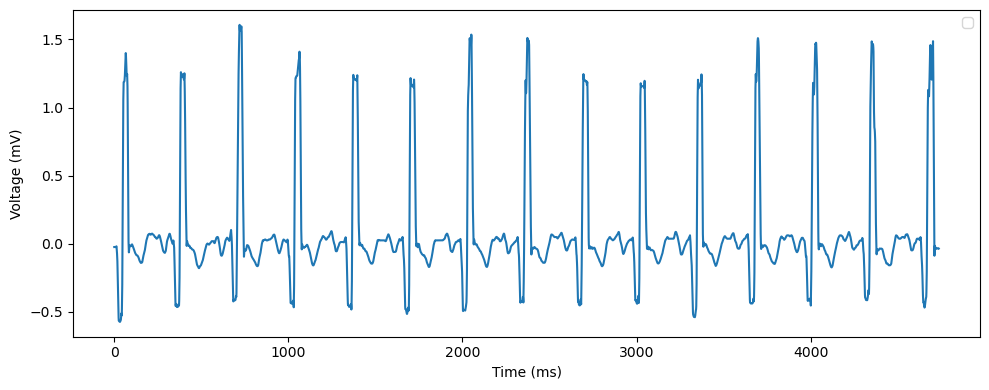

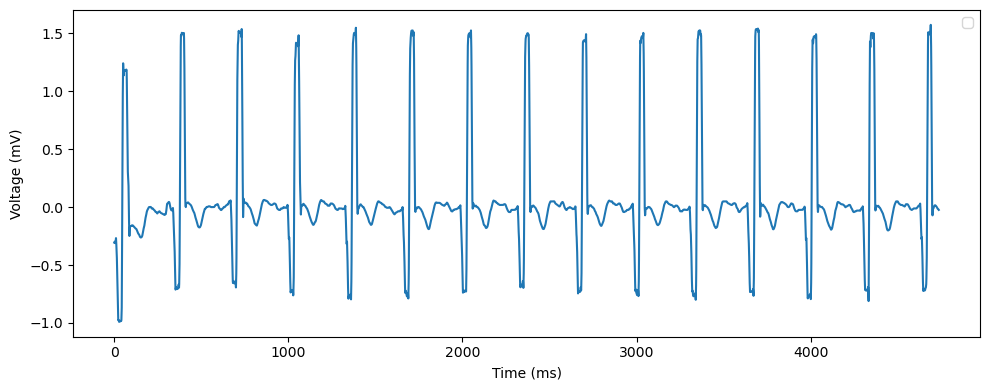

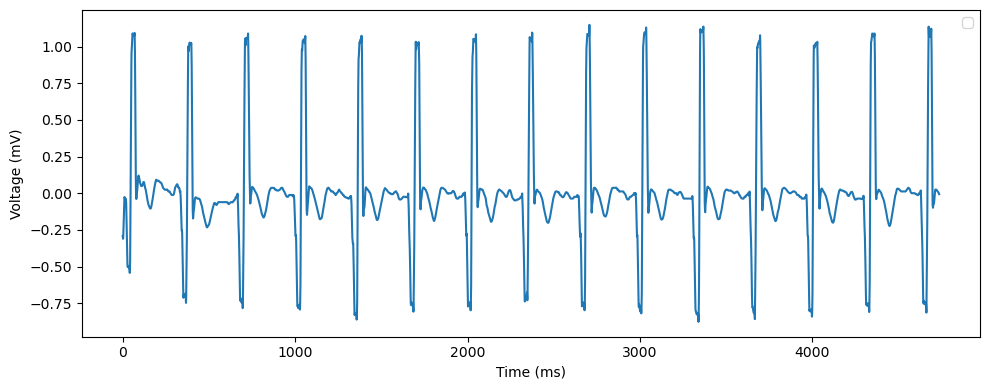

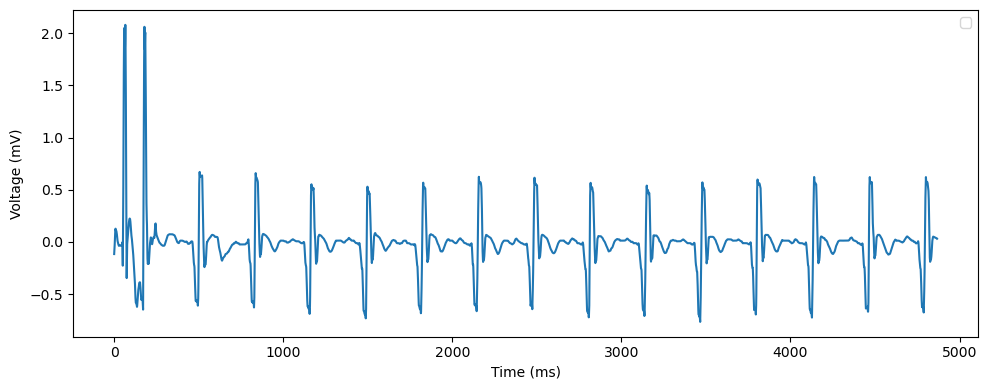

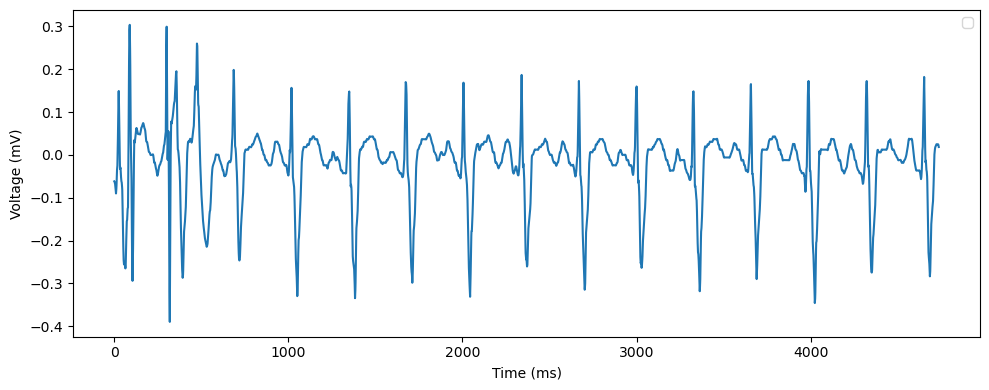

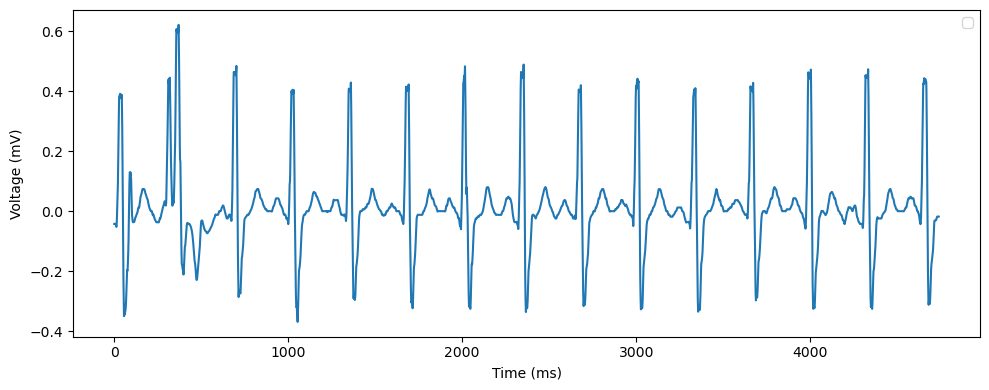

In [13]:
image = 'ecg_signals_12x1_Rythm_Normal/11442_hr-0.png'

# Optional WFDB path for metrics: prefix of matching .dat and .hea files
wfdb_path = 'ecg_signals_12x1_Rythm_Normal/11442_hr'

# Process image
ecg_image = ECGImage(box_model, segmentation_model, lead_name_model, pulse_model, image, wfdb_path)
ecg_image.preprocess_image()
ecg_image.segment_leads()
ecg_image.make_segmentation_mask()
ecg_image.find_row_centers()
ecg_image.get_roi()
ecg_image.extract_lead_boxes()
ecg_image.extract_lead_name_boxes()
ecg_image.extract_reference_pulses()
ecg_image.get_reference_scale()
ecg_image.make_grid()
ecg_image.extract_signals()

# Optional: if WFDB files available
ecg_image.calculate_metrics_ptb()

# Optional: save time series as .npy
ecg_image.save_signals_as_wfdb('example', directory='Saved_signals')

# Visualize results
plot_image(ecg_image.image, title='Original Image', show_axis=False)
plot_image(ecg_image.processed_image, title='Processed Image', show_axis=False)

ecg_image.visualize_boxes(task='Lead name', show_axis=False)
ecg_image.visualize_boxes(task='Lead box', show_axis=False)
ecg_image.visualize_boxes(task='Reference pulse', show_axis=False)

ecg_image.visualize_segmentation(show_boxes=False, show_axis=False, fill_mask=True, thickness=1)
plot_image(ecg_image.mask_image, title='Segmentation mask', show_axis=False)

ecg_image.visualize_grid()

ecg_image.plot_signals(plot_wfdb=False)

## Calculate layout detection accuracy

In [12]:
folder_paths = [
    'ecg_signals_3x4_None_Cabrera',
    'ecg_signals_3x4_Rythm_Cabrera',
    'ecg_signals_3x4_None_Normal',
    'ecg_signals_3x4_Rythm_Normal',
    
    'ecg_signals_4x3_None_Cabrera',
    'ecg_signals_4x3_Rythm_Cabrera',
    'ecg_signals_4x3_None_Normal',
    'ecg_signals_4x3_Rythm_Normal',
    
    'ecg_signals_6x2_None_Cabrera',
    'ecg_signals_6x2_Rythm_Cabrera',
    'ecg_signals_6x2_None_Normal',
    'ecg_signals_6x2_Rythm_Normal',
    
    'ecg_signals_12x1_None_Cabrera',
    'ecg_signals_12x1_Rythm_Cabrera',
    'ecg_signals_12x1_None_Normal',
    'ecg_signals_12x1_Rythm_Normal'
]

folder_layout_map = {folder: parse_layout_from_folder(folder) for folder in folder_paths}

overall_total = 0
overall_success = 0
failed_images = []

print("\n=== Per-folder Results ===")

for folder_path in folder_paths:
    expected_layout, calib = folder_layout_map[folder_path]
    
    file_paths = glob.glob(os.path.join(folder_path, "*.png"))
    folder_total = 0
    folder_success = 0

    for file_path in file_paths:
        image_name = os.path.splitext(os.path.basename(file_path))[0]

        ecg_image = ECGImage(box_model, segmentation_model, lead_name_model, pulse_model, file_path)

        try:
            ecg_image.preprocess_image()
            ecg_image.segment_leads()
            ecg_image.make_segmentation_mask()
            ecg_image.find_row_centers()
            ecg_image.get_roi()
            ecg_image.extract_lead_boxes()
            ecg_image.extract_lead_name_boxes()
            ecg_image.extract_reference_pulses()
            ecg_image.get_reference_scale()
            ecg_image.make_grid()
        except Exception as e:
            print(f"Processing failed for {image_name}: {e}")
            failed_images.append(f"{image_name} (exception)")
            continue

        layout_key = next((k for k, v in ecg_image.standard_layouts.items() if v == ecg_image.layout), None)

        folder_total += 1
        overall_total += 1

        if layout_key == expected_layout and ecg_image.has_calibration_pulse == calib:
            folder_success += 1
            overall_success += 1
        else:
            failed_images.append(f"{image_name} (layout={layout_key}, calib={ecg_image.has_calibration_pulse})")

    success_rate = 100 * folder_success / folder_total if folder_total else 0
    print(f"{os.path.basename(folder_path)} — {folder_success}/{folder_total} correct ({success_rate:.1f}%)")

total_rate = 100 * overall_success / overall_total if overall_total else 0
print("\n=== Overall Success ===")
print(f"Total: {overall_success}/{overall_total} correct ({total_rate:.1f}%)")

if failed_images:
    print("\n=== Failed Images ===")
    for img in failed_images:
        print(f" - {img}")



=== Per-folder Results ===
ecg_signals_4x3_Rythm_Cabrera — 71/100 correct (71.0%)

=== Overall Success ===
Total: 71/100 correct (71.0%)

=== Failed Images ===
 - 17689_hr-0 (layout=(4, 3, False), calib=True)
 - 20313_hr-0 (layout=(4, 3, False), calib=True)
 - 20291_hr-0 (layout=(4, 3, False), calib=True)
 - 17994_hr-0 (layout=(4, 3, False), calib=True)
 - 17655_hr-0 (layout=(4, 3, False), calib=True)
 - 17920_hr-0 (layout=(4, 3, False), calib=True)
 - 20184_hr-0 (layout=(4, 3, False), calib=True)
 - 17520_hr-0 (layout=(4, 3, False), calib=True)
 - 17804_hr-0 (layout=(4, 3, False), calib=True)
 - 17281_hr-0 (layout=(4, 3, False), calib=True)
 - 20436_hr-0 (layout=(4, 3, False), calib=True)
 - 20055_hr-0 (layout=(4, 3, False), calib=True)
 - 17843_hr-0 (layout=(4, 3, False), calib=True)
 - 17433_hr-0 (layout=(4, 3, False), calib=True)
 - 17286_hr-0 (layout=(4, 3, False), calib=True)
 - 20319_hr-0 (layout=(4, 3, False), calib=True)
 - 20223_hr-0 (layout=(4, 3, False), calib=True)
 - 177

## Calculate digitization metrics

In [5]:
pearson_score = []
rmse_score = []
snr_score = []

per_lead_scores = {} 

i = 0
j = 0

folder_path = "test_set"
for file_path in glob.glob(os.path.join(folder_path, "*.dat"))[:20]:
    i += 1
    wfdb_path = f"{folder_path}/{os.path.splitext(os.path.basename(file_path))[0]}"
    image = f"{wfdb_path}-0.png"

    try:
        ecg_image = ECGImage(box_model, segmentation_model, lead_name_model, pulse_model, image, wfdb_path)

        ecg_image.preprocess_image()
        ecg_image.segment_leads()
        ecg_image.make_segmentation_mask()
        ecg_image.find_row_centers()
        ecg_image.get_roi()
        ecg_image.extract_lead_boxes()
        ecg_image.extract_lead_name_boxes()
        ecg_image.extract_reference_pulses()
        ecg_image.get_reference_scale()
        ecg_image.make_grid()
        ecg_image.extract_signals()
        ecg_image.calculate_metrics_ptb(plot_signals=False, per_lead_scores=per_lead_scores)
    except:
        print(f"Error : {image}-0.png")
        j += 1
        continue

    if ecg_image.average_pearson < 0.60:
        print(f"Not Good : {image}-0.png")
        j += 1
        continue

    pearson_score.append(ecg_image.average_pearson)
    rmse_score.append(ecg_image.average_rmse)
    snr_score.append(ecg_image.average_snr)

    print(f" Image : {image}-0.png = {ecg_image.average_pearson:.3f}")

print(f"\nOverall Metrics:")
print(f"Pearson : {np.mean(pearson_score):.3f}")
print(f"RMSE    : {np.mean(rmse_score):.3f}")
print(f"SNR     : {np.mean(snr_score):.2f} dB")
print(f"Failures: {j} / {i} = {j/i:.2%}")

print("\nPer-lead Average Metrics:")
for lead, scores in per_lead_scores.items():
    mean_pearson = np.mean(scores['pearson'])
    mean_rmse = np.mean(scores['rmse'])
    mean_snr = np.mean(scores['snr'])
    mean_pval = np.mean(scores['pval'])

    print(f"  {lead}: Pearson={mean_pearson:.3f}, RMSE={mean_rmse:.3f}, "
          f"SNR={mean_snr:.2f} dB, p-value={mean_pval:.2e}")

 Image : test_set/16238_hr-0.png-0.png = 0.844
 Image : test_set/16256_hr-0.png-0.png = 0.739
 Image : test_set/21784_hr-0.png-0.png = 0.727
 Image : test_set/01647_hr-0.png-0.png = 0.849
Error : test_set/08913_hr-0.png-0.png
 Image : test_set/07734_hr-0.png-0.png = 0.723
 Image : test_set/18713_hr-0.png-0.png = 0.793
Not Good : test_set/00518_hr-0.png-0.png
 Image : test_set/00723_hr-0.png-0.png = 0.866
 Image : test_set/12341_hr-0.png-0.png = 0.835
 Image : test_set/05436_hr-0.png-0.png = 0.714
 Image : test_set/14952_hr-0.png-0.png = 0.871
 Image : test_set/01344_hr-0.png-0.png = 0.859
 Image : test_set/06750_hr-0.png-0.png = 0.853
Error : test_set/05445_hr-0.png-0.png
 Image : test_set/09433_hr-0.png-0.png = 0.882
Not Good : test_set/02406_hr-0.png-0.png
 Image : test_set/16940_hr-0.png-0.png = 0.827
 Image : test_set/18837_hr-0.png-0.png = 0.842
 Image : test_set/16462_hr-0.png-0.png = 0.808

Overall Metrics:
Pearson : 0.815
RMSE    : 0.046
SNR     : 4.76 dB
Failures: 4 / 20 = 20.